In [1]:
import pandas as pd

# Load the dataset
df = pd.read_json("all_restaurants_combined.json")

# Extract 'city' from 'location'
df['city'] = df['location'].apply(lambda loc: loc.get('locality') if isinstance(loc, dict) else None)

# Extract 'types' from 'categories' (each category is a dict with a 'name')
df['types'] = df['categories'].apply(lambda cats: [cat['name'] for cat in cats if isinstance(cat, dict) and 'name' in cat] if isinstance(cats, list) else None)

# Drop rows with missing city or types
df = df.dropna(subset=['city', 'types'])

# Only keep rows where 'types' is a list
df = df[df['types'].apply(lambda x: isinstance(x, list))]

# Explode types into individual rows
df_exploded = df.explode('types')

# Count of each type per city
type_counts = df_exploded.groupby(['city', 'types']).size().reset_index(name='count')

# Total number of restaurants per city
city_totals = df_exploded.groupby('city').size().reset_index(name='total')

# Merge and calculate type share per city
merged = type_counts.merge(city_totals, on='city')
merged['type_share'] = merged['count'] / merged['total']

# View most represented types per city
print(merged.sort_values(by=['city', 'type_share'], ascending=[True, False]).head(20))


             city                     types  count  total  type_share
6         Astoria                Restaurant      4     14    0.285714
1         Astoria               Beer Garden      2     14    0.142857
2         Astoria                      Café      2     14    0.142857
3         Astoria               Coffee Shop      2     14    0.142857
5         Astoria               Music Venue      2     14    0.142857
0         Astoria       American Restaurant      1     14    0.071429
4         Astoria                     Diner      1     14    0.071429
7   Beverly Hills       American Restaurant      3     17    0.176471
12  Beverly Hills          Greek Restaurant      2     17    0.117647
8   Beverly Hills        Chinese Restaurant      1     17    0.058824
9   Beverly Hills              Cocktail Bar      1     17    0.058824
10  Beverly Hills               Coffee Shop      1     17    0.058824
11  Beverly Hills        Frozen Yogurt Shop      1     17    0.058824
13  Beverly Hills   

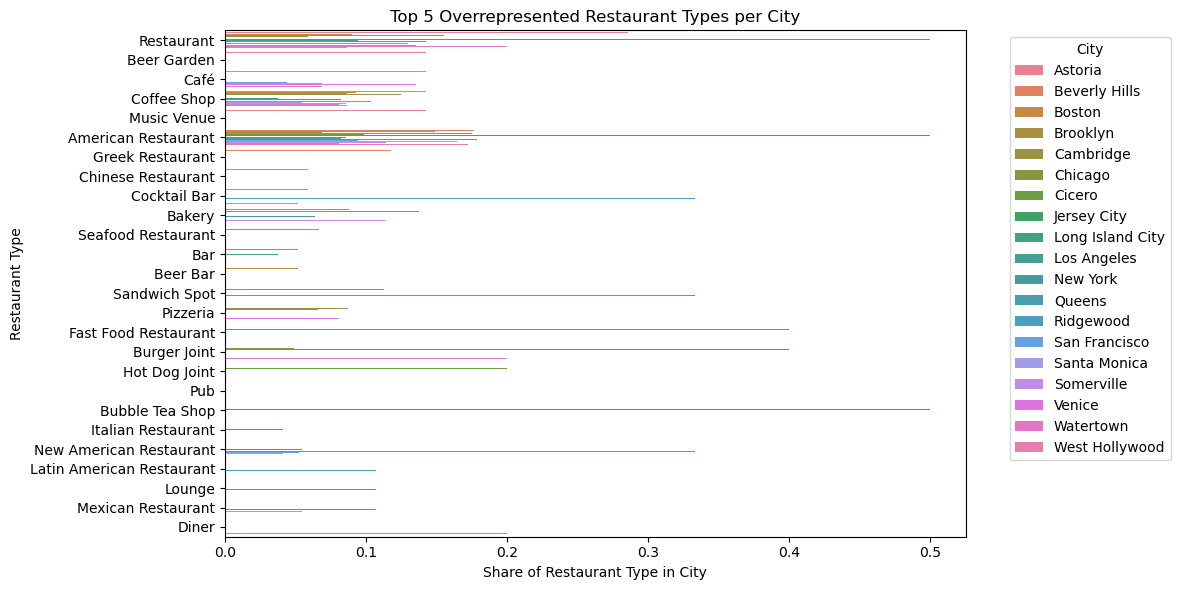

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top N types per city
top_types = (
    merged.sort_values(['city', 'type_share'], ascending=[True, False])
    .groupby('city')
    .head(5)
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_types, x='type_share', y='types', hue='city')
plt.xlabel('Share of Restaurant Type in City')
plt.ylabel('Restaurant Type')
plt.title('Top 5 Overrepresented Restaurant Types per City')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
